***1. Импортиране на необходими библиотеки и функции на Python***

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

# Checking the system's device availability onfiguration
device_name = tf.config.experimental.list_physical_devices('GPU')
if device_name:
    print("Available device for tensorflow to utilise:", tf.config.experimental.get_device_details(device_name[0])['device_name'])
else:
    print("Used device: CPU")

Available device for tensorflow to utilise: NVIDIA GeForce GTX 1050


***2. Зареждане на дейтасет***

In [2]:
#data = pd.read_csv('dataset.csv') # 1195 entries - Dataset number 1 from the dataset folder
data = pd.read_csv('updated_dataset.csv') #1000 entries - Dataset number 2 from the dataset folder, aproximately the same results at the end of the notebook
data.info()

df = pd.DataFrame(data)
print("Dataframe dimensions (rows, cols): ", df.shape)
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1000 non-null   object 
 1   MDVP:Fo(Hz)       1000 non-null   float64
 2   MDVP:Fhi(Hz)      1000 non-null   float64
 3   MDVP:Flo(Hz)      1000 non-null   float64
 4   MDVP:Jitter(%)    1000 non-null   float64
 5   MDVP:Jitter(Abs)  1000 non-null   float64
 6   MDVP:RAP          1000 non-null   float64
 7   MDVP:PPQ          1000 non-null   float64
 8   Jitter:DDP        1000 non-null   float64
 9   MDVP:Shimmer      1000 non-null   float64
 10  MDVP:Shimmer(dB)  1000 non-null   float64
 11  Shimmer:APQ3      1000 non-null   float64
 12  Shimmer:APQ5      1000 non-null   float64
 13  MDVP:APQ          1000 non-null   float64
 14  Shimmer:DDA       1000 non-null   float64
 15  NHR               1000 non-null   float64
 16  HNR               1000 non-null   float64
 

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,153.690810,196.347538,115.745132,0.008355,-0.000756,0.000997,0.002107,0.011554,0.029773,0.279411,...,0.047233,0.022846,21.878464,0.541000,0.501727,0.719190,-5.664489,0.228612,2.380804,0.207028
std,41.118699,90.610538,43.150228,0.049892,0.051954,0.050030,0.052705,0.051688,0.055981,0.200925,...,0.060271,0.064964,4.380174,0.498566,0.116265,0.075250,1.091801,0.096210,0.383211,0.106041
min,88.251290,102.058640,65.409106,-0.096191,-0.099481,-0.098051,-0.097918,-0.095253,-0.088735,-0.006064,...,-0.082413,-0.094861,8.371259,0.000000,0.204309,0.524460,-8.052390,-0.079598,1.360471,-0.049922
25%,117.300770,134.649840,83.978679,-0.023519,-0.040183,-0.035915,-0.040220,-0.024923,-0.004180,0.147010,...,0.005118,-0.021715,19.231944,0.000000,0.415725,0.667004,-6.453216,0.159837,2.095048,0.129704
50%,148.524145,173.031329,104.189730,0.005195,0.000030,0.002221,0.002450,0.008425,0.026699,0.222786,...,0.042459,0.013572,22.055828,1.000000,0.500665,0.719728,-5.682895,0.229845,2.361228,0.195790
75%,181.238000,223.982780,138.899443,0.045451,0.038016,0.034069,0.041035,0.050025,0.069317,0.360210,...,0.092206,0.062455,25.066479,1.000000,0.587421,0.771167,-5.009067,0.295098,2.601174,0.271257
max,260.180301,592.056127,239.218035,0.113473,0.099963,0.107326,0.107001,0.151211,0.201435,1.348997,...,0.259888,0.409777,33.131842,1.000000,0.775322,0.911228,-2.338745,0.527858,3.766771,0.622283


***3. Валидиране на заредения дейтасет и анализ на данните в него***

Dataframe duplicate rows:  0
Dataframe N/A values troughout the columns:
 name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


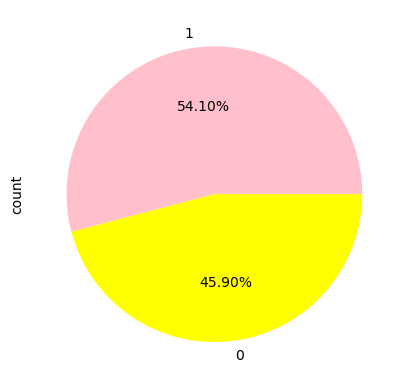

In [4]:
print("Dataframe duplicate rows: ", df.duplicated().sum())
print("Dataframe N/A values troughout the columns:\n", df.isnull().sum())

# BAD PRACTICE BELLOW:
df.status = np.where(df.status>0.75,1,0) # The status column is a float64 type and we want 
                                         # convert it to boolean in order to have a clear
                                         # definition of the dataset examined people's Parkinson status - positive/negative.
                                         # Accepting all values > 0.75 as Parkinson positive. (Our assumption, not stated anywhere in the dataset)
# Display if there are null values for any of the columns
df['status'].value_counts().plot(
    kind='pie',
    autopct='%0.2f%%',
    colors=['pink', 'yellow']  
)
# Pie chart distribution of Parkinson positive and negative cases in the dataset (ideally 50%/50% if the dataset is balanced).
plt.show()

In [5]:
# Analyse the outliers (but keep them included in the dataset because of the matter of the problem that we are solving - clinical data)
def display_outliers_iqr(data):
    outliers_dict = {}
    for column in data.select_dtypes(include=['float64', 'int64']).columns: 
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        if not outliers.empty:
            outliers_dict[column] = outliers
            print(f"Outliers in {column}: {len(outliers)} detected")
    
    return outliers_dict

outliers_by_column = display_outliers_iqr(df)

# Check the total numbers of Parkinson positive and negative samples (1 = positive, 0 = negative).
df['status'].value_counts()

Outliers in MDVP:Fhi(Hz): 55 detected
Outliers in MDVP:Flo(Hz): 45 detected
Outliers in MDVP:Shimmer: 1 detected
Outliers in MDVP:Shimmer(dB): 51 detected
Outliers in MDVP:APQ: 1 detected
Outliers in Shimmer:DDA: 4 detected
Outliers in NHR: 17 detected
Outliers in HNR: 18 detected
Outliers in spread1: 8 detected
Outliers in spread2: 5 detected
Outliers in D2: 8 detected
Outliers in PPE: 11 detected


status
1    541
0    459
Name: count, dtype: int64

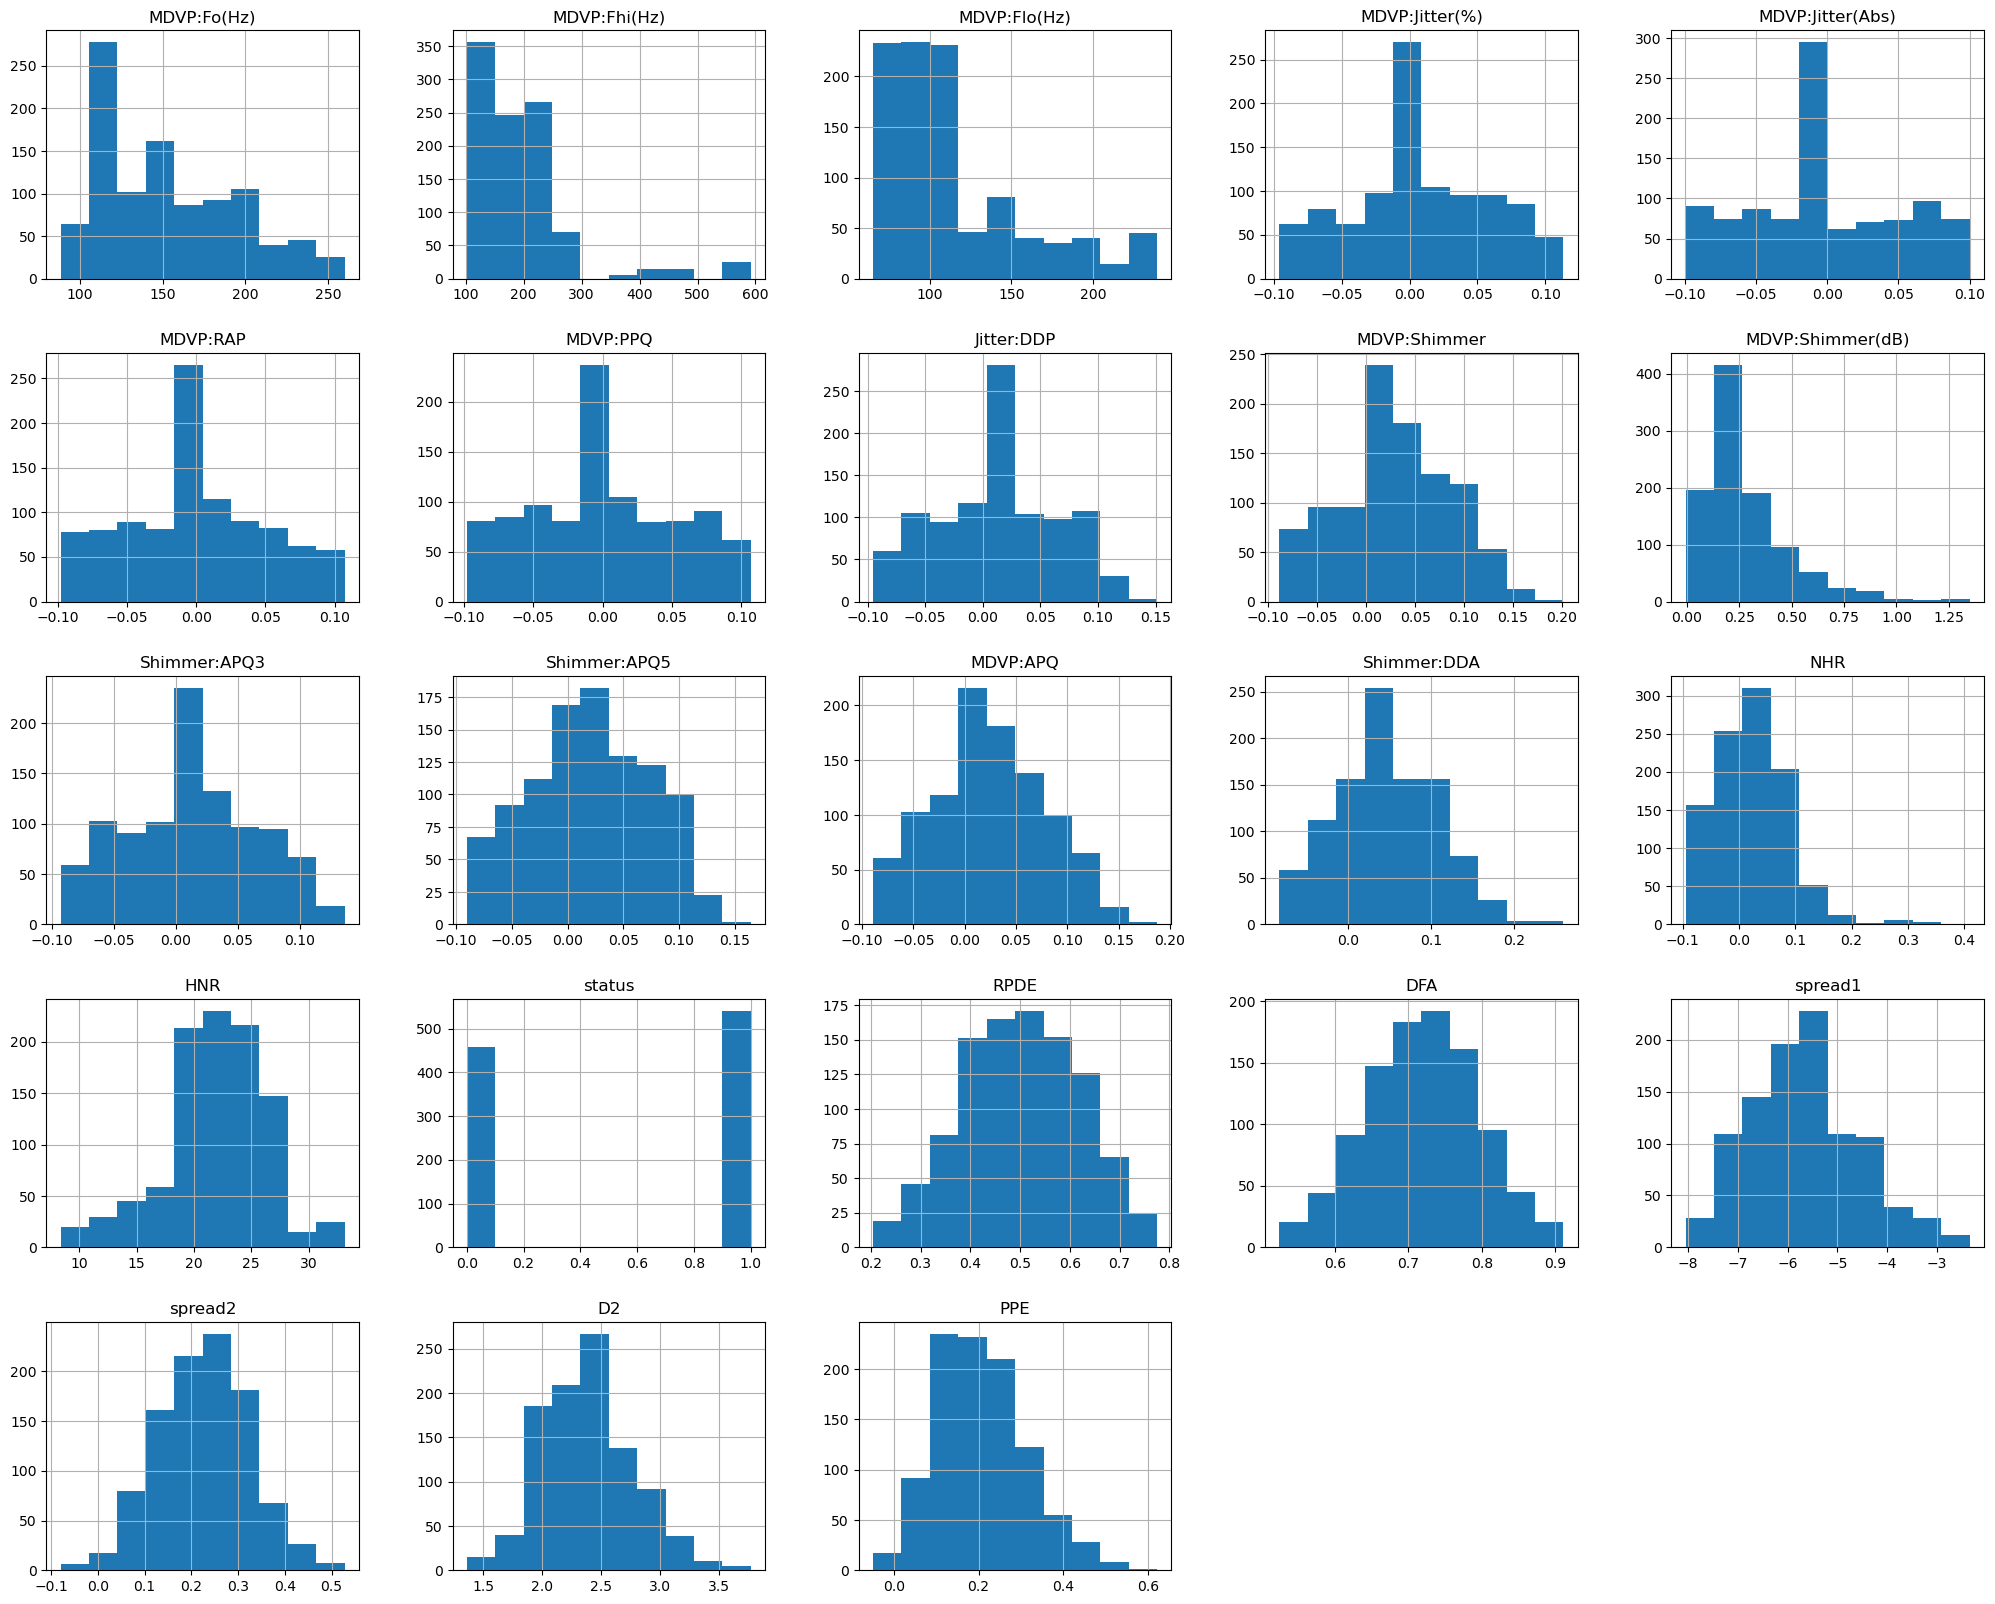

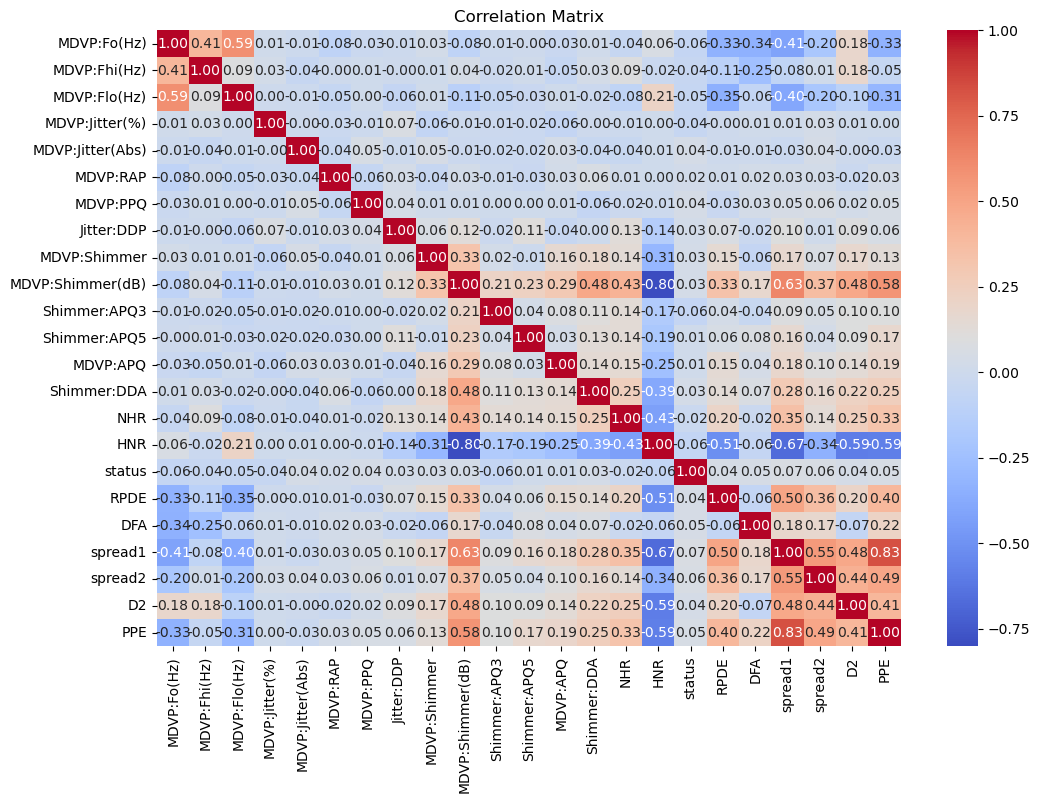

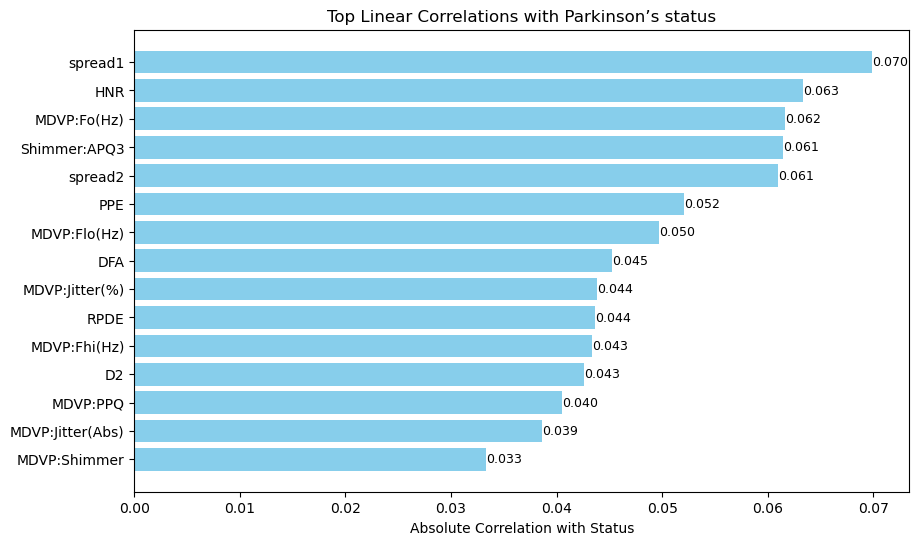

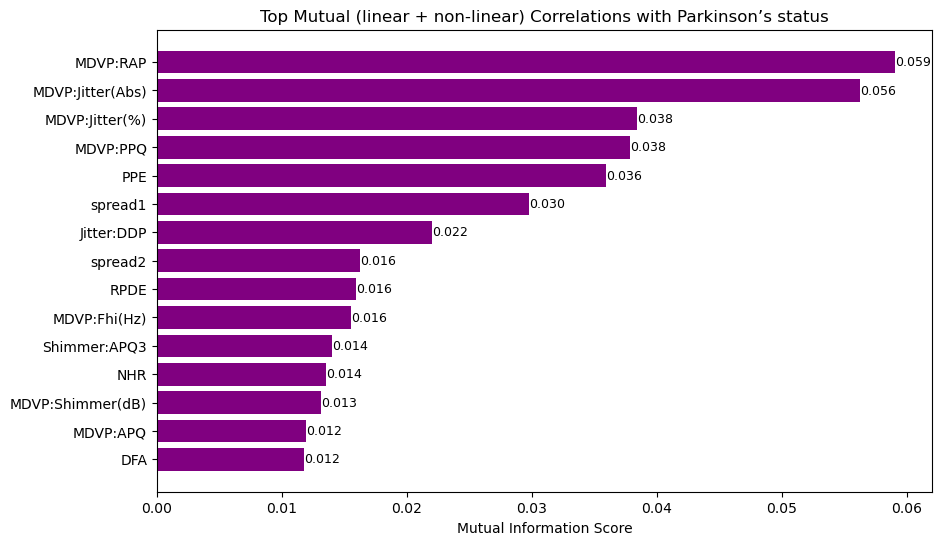

In [6]:
# Analyse the critical features that correlate the most with the status of the patient 

df.hist(figsize=(25,20));

features = df.drop(columns=['name'])
corr_matrix = features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

status_corr = corr_matrix['status']

# Visual representation of the feature selection based on linear correlation with the status
def plot_linear_scores(status_corr, top_n=15):
    # Exclude 'status' itself, take absolute values, sort descending, and select top N
    absolute_corr = status_corr.drop('status').abs().sort_values(ascending=False).head(top_n)
    width = np.arange(len(absolute_corr))
    ticks = list(absolute_corr.index)
    
    # Plot horizontal bars
    plt.figure(figsize=(10, 6))
    for i, (feature, score) in enumerate(zip(ticks, absolute_corr)):
        color = 'skyblue'
        # Use len(absolute_corr) - 1 - i to invert the order (descending visually)
        plt.barh(len(absolute_corr) - 1 - i, score, color=color)
        
        # Annotate bars with correlation values
        plt.text(score, len(absolute_corr) - 1 - i, f'{score:.3f}', va='center', ha='left', fontsize=9, color='black')
    
    # Set y-ticks with the reversed order
    plt.yticks(width, ticks[::-1])  # Reverse ticks to match descending order
    plt.xlabel('Absolute Correlation with Status')
    plt.title('Top Linear Correlations with Parkinson’s status')
    plt.show()
    
plot_linear_scores(status_corr)

# Using only linear relationships correlation might not be very accurate way to browse the most important features.
# Using the function sklearn's mutual_info_classif function is especially designed to solve this selection task based on both linear and nonlinear relationships in the data.

# Extract features and target for mutual information
X = features.drop(columns=['status'])  # Features excluding 'status'
y = df['status']  # Target variable

# Compute mutual information scores
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns)

# Function to plot mutual information scores
def plot_non_linear_scores(mi_series, top_n=15):
    # Sort by mutual information (descending) and select top N
    sorted_mi = mi_series.sort_values(ascending=False).head(top_n)
    width = np.arange(len(sorted_mi))
    ticks = list(sorted_mi.index)
    
    # Plot horizontal bars
    plt.figure(figsize=(10, 6))
    for i, (feature, score) in enumerate(zip(ticks, sorted_mi)):
        color = 'purple'
        # Invert order for descending visual (highest at top)
        plt.barh(len(sorted_mi) - 1 - i, score, color=color)
        
        # Annotate bars with MI values
        plt.text(score, len(sorted_mi) - 1 - i, f'{score:.3f}', va='center', ha='left', fontsize=9, color='black')
    
    # Set y-ticks with reversed order
    plt.yticks(width, ticks[::-1])
    plt.xlabel('Mutual Information Score')
    plt.title('Top Mutual (linear + non-linear) Correlations with Parkinson’s status')
    plt.show()
    
plot_non_linear_scores(mi_series)

***4. Подготвяне на данните за тренирането на модел***

In [7]:
def split_and_prepare_dataset(df, target_column='status', feature_exclude=['name'], random_state=42):
# Separate features (X) and target (y)
    X = df.drop(columns=feature_exclude + [target_column])
    y = df[target_column]
    
    # First split: 80% train, 20% temp (to be split into val and test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, train_size=0.8, random_state=random_state, stratify=y
    )
    
    # Second split: 50% of temp for validation, 50% for test (10% each of original)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, train_size=0.5, random_state=random_state, stratify=y_temp
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training data
    X_val_scaled = scaler.transform(X_val)          # Transform validation data
    X_test_scaled = scaler.transform(X_test)        # Transform test data
    
    # Print the sizes of each set
    print(f"Training set: {X_train_scaled.shape[0]} samples ({X_train_scaled.shape[0]/df.shape[0]*100:.1f}%)")
    print(f"Validation set: {X_val_scaled.shape[0]} samples ({X_val_scaled.shape[0]/df.shape[0]*100:.1f}%)")
    print(f"Test set: {X_test_scaled.shape[0]} samples ({X_test_scaled.shape[0]/df.shape[0]*100:.1f}%)")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

# Example usage with df from your Parkinson's dataset
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = split_and_prepare_dataset(df)


Training set: 800 samples (80.0%)
Validation set: 100 samples (10.0%)
Test set: 100 samples (10.0%)


***5. Изграждане и компилиране на модел - Невронна мрежа***

In [8]:
# Define the sequential model
nn_model = Sequential()              
nn_model.add(Dense(units=64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.5))
nn_model.add(Dense(units=32, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))
nn_model.add(Dense(units=16, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.2))
nn_model.add(Dense(units=1, activation='sigmoid'))
nn_model.summary()

nn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,
                               restore_best_weights=True) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1472      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

Starting training...
Epoch 1/100
13/13 [==============================] - 2s 27ms/step - loss: 0.8473 - accuracy: 0.5063 - val_loss: 0.6978 - val_accuracy: 0.5300
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 0.8093 - accuracy: 0.5312 - val_loss: 0.6960 - val_accuracy: 0.5300
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 0.8016 - accuracy: 0.5350 - val_loss: 0.6963 - val_accuracy: 0.5500
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.7906 - accuracy: 0.5512 - val_loss: 0.6992 - val_accuracy: 0.5300
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 0.7560 - accuracy: 0.5325 - val_loss: 0.7002 - val_accuracy: 0.5300
Epoch 6/100
13/13 [==============================] - 0s 10ms/step - loss: 0.7566 - accuracy: 0.5487 - val_loss: 0.6989 - val_accuracy: 0.5600
Epoch 7/100
13/13 [==============================] - 0s 10ms/step - loss: 0.7681 - accuracy: 0.5375 - val_loss: 0.6987 - val_accur

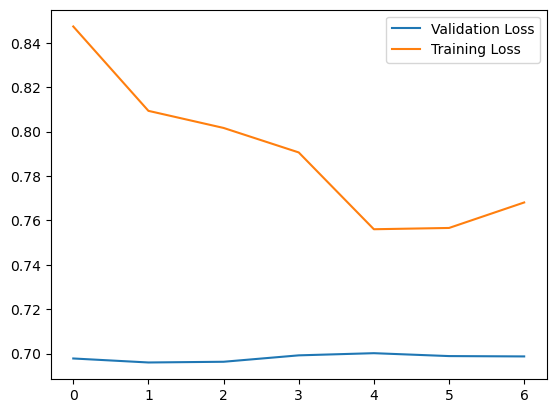

In [9]:
print("Starting training...")
start_time = time.time()

history = nn_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),batch_size=64,epochs=100,verbose=True,callbacks=[early_stopping])

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")
print(f"Start time: {time.ctime(start_time)}")
print(f"End time: {time.ctime(end_time)}")

print("Loss function plot for the validation metric during the training:")
val_loss = history.history['val_loss']
loss = history.history['loss']
sns.lineplot(x=range(len(val_loss)), y=val_loss, label='Validation Loss')
sns.lineplot(x=range(len(loss)), y=loss, label='Training Loss')
plt.legend()

***6. Трениране на модела и изкарване на характеристики отностно сполучливостта му***

In [10]:
# Function for confusion matrix plotting
def plot_confusion_matrix(conf_matrix, plot_title, model_name):
    print("Confusion Matrix:\n")
    annotations = np.empty_like(conf_matrix, dtype=object)
    total = conf_matrix.sum()
    tn, fp, fn, tp = conf_matrix.ravel()
    annotations[0, 0] = f"True Positive: {tp} ({tp / total * 100:.1f}%)"
    annotations[1, 0] = f"False Positive: {fp} ({fp / total * 100:.1f}%)"
    annotations[0, 1] = f"False Negative: {fn} ({fn / total * 100:.1f}%)"
    annotations[1, 1] = f"True Negative: {tn} ({tn / total * 100:.1f}%)"

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=annotations, fmt="", cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix with Metrics for the ' + model_name + " model")
    plt.show()
    print()

# Function for classification report printing
def print_classification_report(y, y_pred):
    print("Classification Report:\n")
    report = classification_report(y_val, y_val_pred, output_dict=True)
    print(report)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    print(f"\nPrecision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

4/4 [==============================] - 0s 3ms/step

Validation Set Performance:
Confusion Matrix:



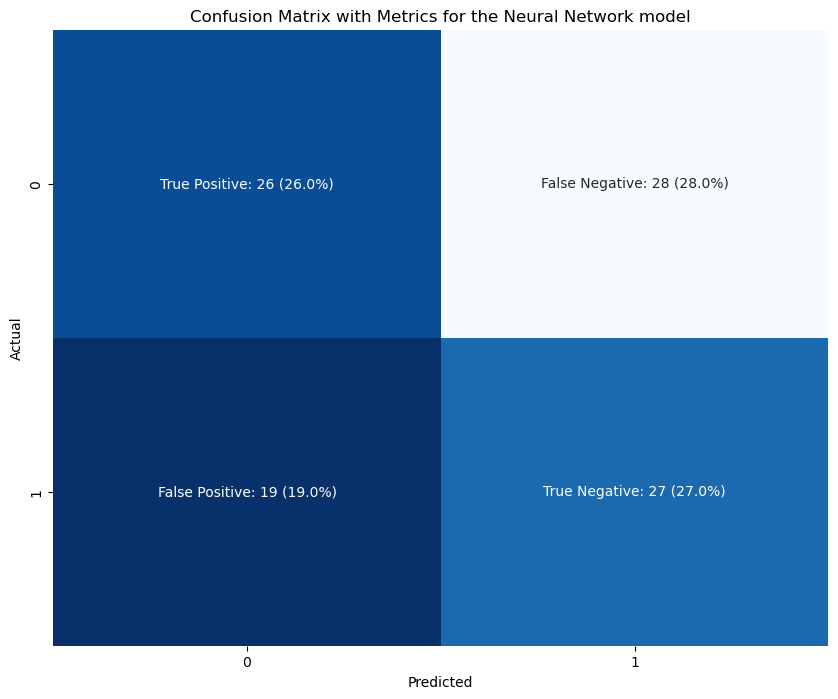


Classification Report:

{'0': {'precision': 0.4909090909090909, 'recall': 0.5869565217391305, 'f1-score': 0.5346534653465347, 'support': 46.0}, '1': {'precision': 0.5777777777777777, 'recall': 0.48148148148148145, 'f1-score': 0.5252525252525252, 'support': 54.0}, 'accuracy': 0.53, 'macro avg': {'precision': 0.5343434343434343, 'recall': 0.534219001610306, 'f1-score': 0.5299529952995299, 'support': 100.0}, 'weighted avg': {'precision': 0.5378181818181819, 'recall': 0.53, 'f1-score': 0.5295769576957696, 'support': 100.0}}

Precision: 0.54
Recall: 0.53
F1 Score: 0.53
Accuracy: 0.53
4/4 [==============================] - 0s 3ms/step

Test Set Performance:
Confusion Matrix:



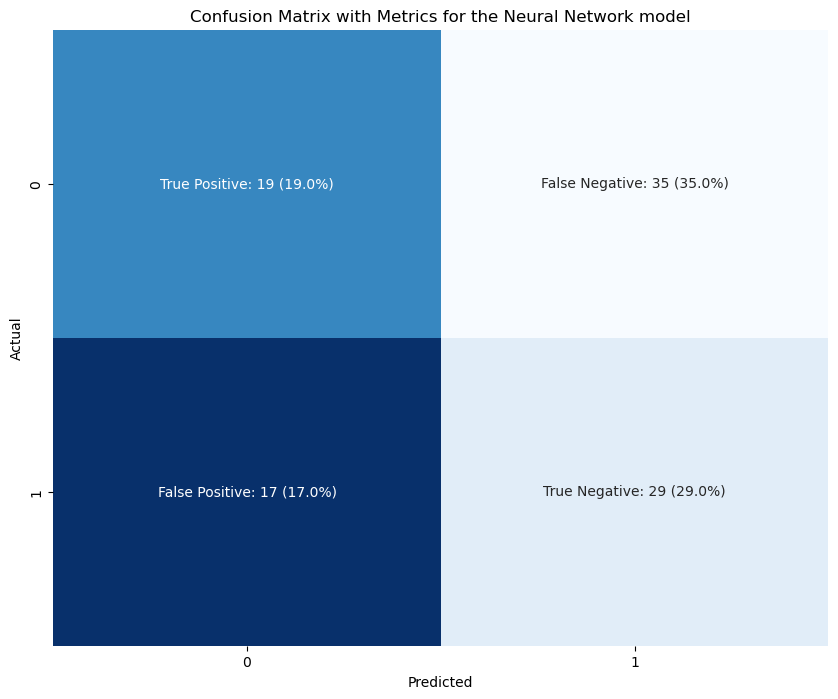


Classification Report:

{'0': {'precision': 0.4909090909090909, 'recall': 0.5869565217391305, 'f1-score': 0.5346534653465347, 'support': 46.0}, '1': {'precision': 0.5777777777777777, 'recall': 0.48148148148148145, 'f1-score': 0.5252525252525252, 'support': 54.0}, 'accuracy': 0.53, 'macro avg': {'precision': 0.5343434343434343, 'recall': 0.534219001610306, 'f1-score': 0.5299529952995299, 'support': 100.0}, 'weighted avg': {'precision': 0.5378181818181819, 'recall': 0.53, 'f1-score': 0.5295769576957696, 'support': 100.0}}

Precision: 0.54
Recall: 0.53
F1 Score: 0.53
Accuracy: 0.53


In [11]:
# Evaluate Neural Network model on the validation set
y_val_pred = nn_model.predict(X_val_scaled)
y_val_pred = (y_val_pred > 0.5).astype(int)
print("\nValidation Set Performance:")
plot_confusion_matrix(confusion_matrix(y_val, y_val_pred), "Validation Set Confusion Matrix", "Neural Network")
print_classification_report(y_val, y_val_pred)

# Evaluate Neural Network model on the test set
y_test_pred = nn_model.predict(X_test_scaled)
y_test_pred = (y_test_pred > 0.5).astype(int)
print("\nTest Set Performance:")
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), "Test Set Confusion Matrix", "Neural Network")
print_classification_report(y_test, y_test_pred)

***7. Трениране на два допълнителни модела (различни от първия) за сверяване на достоверността на получените резултати от първия***

In [12]:
# Define the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=5000,      # Number of trees
    max_depth=100,          # Maximum depth of each tree
    min_samples_split=5,   # Minimum samples to split a node
    min_samples_leaf=2,    # Minimum samples in a leaf
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all available CPU/GPU cores
)

# Print model details
print("Random Forest Model Parameters:")
print(rf_model.get_params())

# Train the model with time tracking
print("Random Forest model training started.")
start_time = time.time()

# Fit the model (no validation data needed during training for Random Forest)
rf_model.fit(X_train_scaled, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")
print(f"Start time: {time.ctime(start_time)}")
print(f"End time: {time.ctime(end_time)}")

Random Forest Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5000, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Random Forest model training started.
Training completed in 11.61 seconds
Start time: Mon Apr  7 23:23:07 2025
End time: Mon Apr  7 23:23:19 2025



Validation Set Performance:
Confusion Matrix:



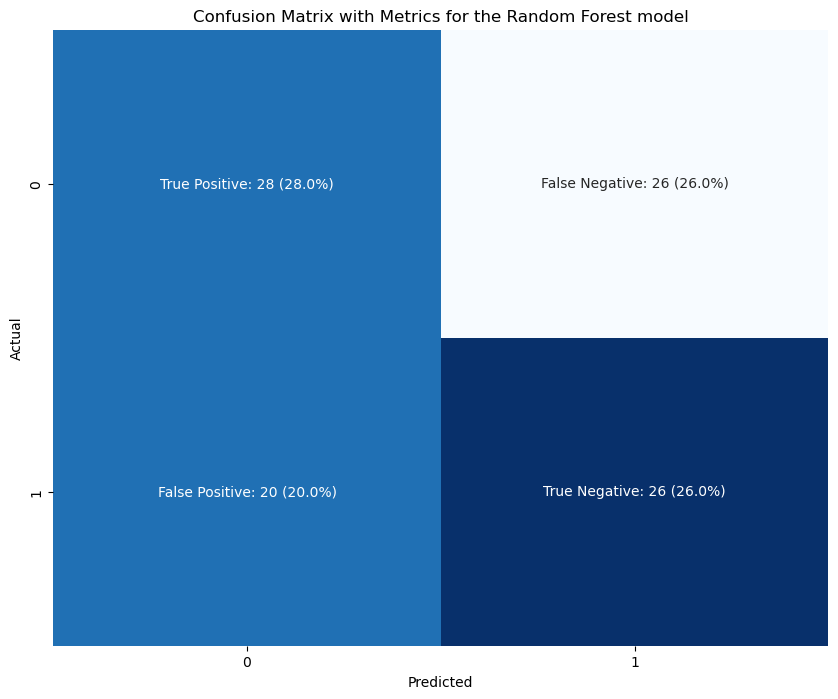


Classification Report:

{'0': {'precision': 0.5, 'recall': 0.5652173913043478, 'f1-score': 0.5306122448979592, 'support': 46.0}, '1': {'precision': 0.5833333333333334, 'recall': 0.5185185185185185, 'f1-score': 0.5490196078431373, 'support': 54.0}, 'accuracy': 0.54, 'macro avg': {'precision': 0.5416666666666667, 'recall': 0.5418679549114331, 'f1-score': 0.5398159263705482, 'support': 100.0}, 'weighted avg': {'precision': 0.545, 'recall': 0.54, 'f1-score': 0.5405522208883553, 'support': 100.0}}

Precision: 0.55
Recall: 0.54
F1 Score: 0.54
Accuracy: 0.54

Test Set Performance:
Confusion Matrix:



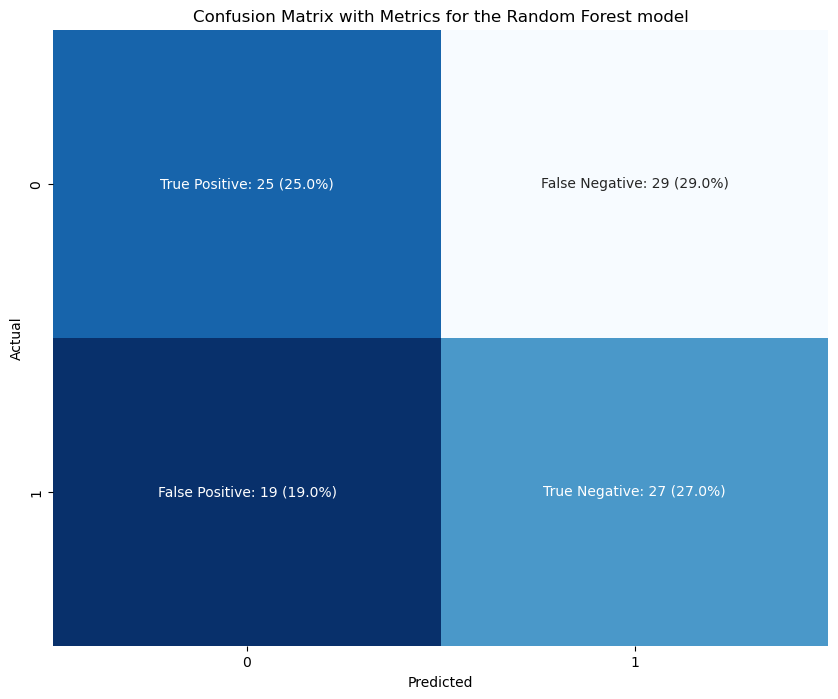


Classification Report:

{'0': {'precision': 0.5, 'recall': 0.5652173913043478, 'f1-score': 0.5306122448979592, 'support': 46.0}, '1': {'precision': 0.5833333333333334, 'recall': 0.5185185185185185, 'f1-score': 0.5490196078431373, 'support': 54.0}, 'accuracy': 0.54, 'macro avg': {'precision': 0.5416666666666667, 'recall': 0.5418679549114331, 'f1-score': 0.5398159263705482, 'support': 100.0}, 'weighted avg': {'precision': 0.545, 'recall': 0.54, 'f1-score': 0.5405522208883553, 'support': 100.0}}

Precision: 0.55
Recall: 0.54
F1 Score: 0.54
Accuracy: 0.54


In [13]:
# Evaluate Random Forest model on the validation set
y_val_pred = rf_model.predict(X_val_scaled)
print("\nValidation Set Performance:")
plot_confusion_matrix(confusion_matrix(y_val, y_val_pred), "Validation Set Confusion Matrix", "Random Forest")
print_classification_report(y_val, y_val_pred)

# Evaluate Random Forest model on the test set
y_test_pred = rf_model.predict(X_test_scaled)
print("\nTest Set Performance:")
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), "Test Set Confusion Matrix", "Random Forest")
print_classification_report(y_test, y_test_pred)

In [14]:
# Define the SVM model
svm_model = SVC(
    C=10.0,               # Regularization parameter (default)
    kernel='rbf',         # Radial Basis Function kernel (non-linear)
    gamma=0.001,          # Kernel coefficient (default: 'scale' = 1 / (n_features * X.var()))
    tol=1e-5,             # Tighter tolerance (more precise convergence)
    random_state=42,      # For reproducibility
    probability=True      # Enable probability estimates (optional, for later use)
)

# Print model details
print("SVM Model Parameters:")
print(svm_model.get_params())

# Train the model with time tracking
print("SVM model training started.")
start_time = time.time()

# Fit the model (no validation data needed during training for SVM)
svm_model.fit(X_train_scaled, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")
print(f"Start time: {time.ctime(start_time)}")
print(f"End time: {time.ctime(end_time)}")

SVM Model Parameters:
{'C': 10.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 1e-05, 'verbose': False}
SVM model training started.
Training completed in 0.19 seconds
Start time: Mon Apr  7 23:23:21 2025
End time: Mon Apr  7 23:23:21 2025



Validation Set Performance:
Confusion Matrix:



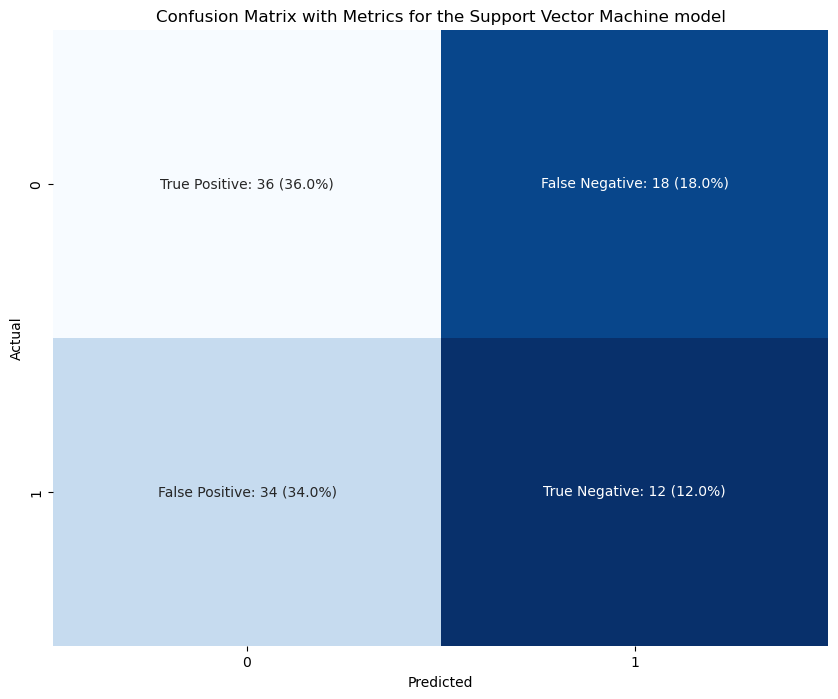


Classification Report:

{'0': {'precision': 0.4, 'recall': 0.2608695652173913, 'f1-score': 0.31578947368421056, 'support': 46.0}, '1': {'precision': 0.5142857142857142, 'recall': 0.6666666666666666, 'f1-score': 0.5806451612903226, 'support': 54.0}, 'accuracy': 0.48, 'macro avg': {'precision': 0.45714285714285713, 'recall': 0.46376811594202894, 'f1-score': 0.44821731748726656, 'support': 100.0}, 'weighted avg': {'precision': 0.4617142857142857, 'recall': 0.48, 'f1-score': 0.4588115449915111, 'support': 100.0}}

Precision: 0.46
Recall: 0.48
F1 Score: 0.46
Accuracy: 0.48

Test Set Performance:
Confusion Matrix:



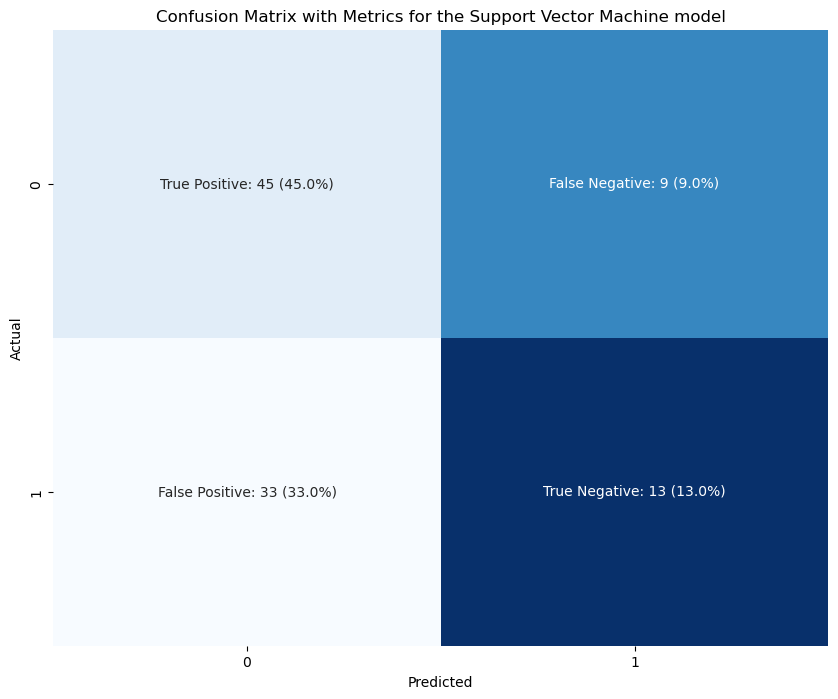


Classification Report:

{'0': {'precision': 0.4, 'recall': 0.2608695652173913, 'f1-score': 0.31578947368421056, 'support': 46.0}, '1': {'precision': 0.5142857142857142, 'recall': 0.6666666666666666, 'f1-score': 0.5806451612903226, 'support': 54.0}, 'accuracy': 0.48, 'macro avg': {'precision': 0.45714285714285713, 'recall': 0.46376811594202894, 'f1-score': 0.44821731748726656, 'support': 100.0}, 'weighted avg': {'precision': 0.4617142857142857, 'recall': 0.48, 'f1-score': 0.4588115449915111, 'support': 100.0}}

Precision: 0.46
Recall: 0.48
F1 Score: 0.46
Accuracy: 0.48


In [15]:
# Evaluate SVM model on validation set
y_val_pred = svm_model.predict(X_val_scaled)
print("\nValidation Set Performance:")
plot_confusion_matrix(confusion_matrix(y_val, y_val_pred), "Validation Set Confusion Matrix", "Support Vector Machine")
print_classification_report(y_val, y_val_pred)

# Evaluate SVM model on the test set
y_test_pred = svm_model.predict(X_test_scaled)
print("\nTest Set Performance:")
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), "Test Set Confusion Matrix", "Support Vector Machine")
print_classification_report(y_test, y_test_pred)

***Резултати:***

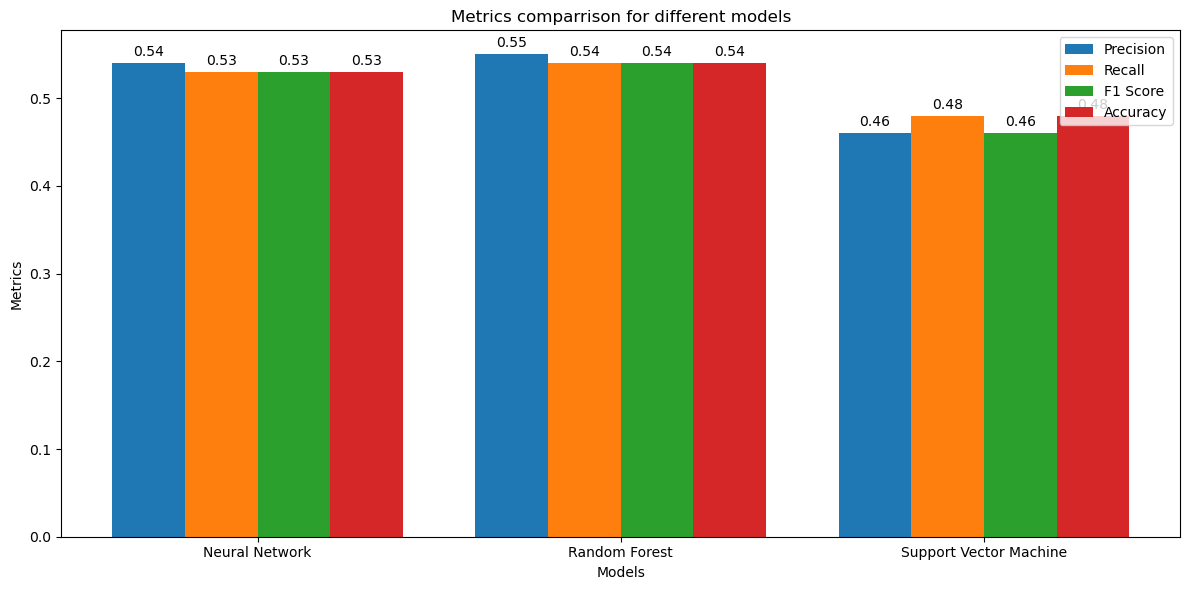

In [16]:
models = ['Neural Network', 'Random Forest', 'Support Vector Machine']
precision = [0.54, 0.55, 0.46]
recall = [0.53, 0.54, 0.48]
f1_score = [0.53, 0.54, 0.46]
accuracy = [0.53, 0.54, 0.48]

x = np.arange(len(models))  
width = 0.2  

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width*1.5, precision, width, label='Precision')
rects2 = ax.bar(x - width/2, recall, width, label='Recall')
rects3 = ax.bar(x + width/2, f1_score, width, label='F1 Score')
rects4 = ax.bar(x + width*1.5, accuracy, width, label='Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Metrics comparrison for different models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

Методологията на изпълнение на този ноутбук:
* зареждане на дейтасет --> 
* валидиране на информацията в него --> 
* [блок с чисто анализираща цел] предварителен анализ на данните от дейтасета чрез корелационни матрици и определяне на ключови фийчъри -->
* зареждането му в структури, подходящи за обучение и тестване на модели --> 
* обучение на модел --> 
* анализ на получени резултати --> 
* сверяване на резултатите с резултати от втори различен тип ML модел (поради ниски резултати от първия модел)

Следваните стъпки предлагат оптимален подход за решаване на задачата за създаване на модел за софтуерно разпознаване на Паркинсон според информация от данни от звуков тип.

Достигнатите точности 40-60% за тренираните модели (при многократни опити с използвани различни параметри), показват недостатъчни взаимовръзки между 23-те характеристики и статуса на изследвания човек. Това означава че за постигане на софтуерно идентифициране на Паркинсон е необходимо извличането на други, по-значими, характеристики от представените 23 в текущия дейтасет. 

Допълнителен пропуск в дейтасета е формата с плаваща запетая на полето "status", което би трябвало да е от булев тип (при обучение трансормирано до 1 и 0). 
Експерименталното причисляване на стойностите над 0.75 към единица, постигна почти балансиран дейтасет, но това причисляване не е правилна операция, защото не е обоснована с доказателства за извършването и. Такова обосноваване е било необходимо да се направи още при създаването на въпросния дейтасет.